# Topic modelling for tweets of covid19

On this first exploratory work, we intend to find and visualize the main topics on a subset of our corpus of tweets about covid19. We perform un unsupervised learning in order to detect emerging topics for our study of the social narratives of the pandemic.

In [2]:
corpus_label = 'dhcovid_texts_2020-04-25_es_ar' # We select all the tweets in spanish for april 25th.
corpus_minilabel = corpus_label.replace('dhcovid_texts_', '')

with open(f'data/{corpus_label}.txt', 'r') as fi:
    tweets=fi.readlines()

In [9]:
with open('data/stopwords-spa.lst', 'r') as s: # Generic Spanish stopwords
    stop_words = s.read()
    
with open("data/stopwords-spa.extra.lst") as s: # This list is modified according to our corpus
    stop_words += s.read()

stop_words = stop_words.split()

with open('data/emojinames.parsed.extras.txt') as fi:
    emoji_labels=fi.read()
emoji_labels= emoji_labels.split()

Predictably, stopwords are of no interest for topic modelling, so we will filter them. And based on the results, we refresh the list of stopwords to eliminate noise (for ex, 'retwitt') or words that are too obvious (for ex, 'covid19'). We will also filter emojis.

## Preprocessing

Topic modelling focuses in nouns, since it is the category that prototypically holds the more information load of a text. We use Stanza (from Stanford NLP) for part of speech detection and lemmatization. Lemmatization reduces all the flexions of a word to the same lemma, a very helpful preprocessing step when dealing with texts in Spanish. 

In [4]:
import stanza
nlp_stanza = stanza.Pipeline('es', processors='tokenize, pos, lemma')

2020-06-19 17:12:10 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| pos       | ancora  |
| lemma     | ancora  |

2020-06-19 17:12:10 INFO: Use device: cpu
2020-06-19 17:12:10 INFO: Loading: tokenize
2020-06-19 17:12:10 INFO: Loading: pos
2020-06-19 17:12:11 INFO: Loading: lemma
2020-06-19 17:12:11 INFO: Done loading processors!


In [5]:
from tqdm import tqdm
stanza_tweets = [nlp_stanza(tweet) for tweet in tqdm(tweets)]

100%|██████████| 2601/2601 [08:51<00:00,  4.89it/s]


In [6]:
for tweet in stanza_tweets[:10]:
    for sent in tweet.sentences:
        for word in sent.words:
            if word.text not in stop_words and word.upos=='NOUN':
                print(word.text, word.lemma, word.upos)

#albertofernandez #albertofernandez NOUN
#laplata #laplata NOUN
casos caso NOUN
joven joven NOUN
años año NOUN
pagina pagina NOUN
informe informe NOUN
community community NOUN
of of NOUN
insurance insurance NOUN
impacto impacto NOUN
perspectivas perspectiva NOUN
parte parte NOUN
equipo equipo NOUN
actualidad actualidad NOUN
pais pais NOUN
supuesto supuesto NOUN
#sanmartin #sanmartin NOUN
cosas cosa NOUN
materia materia NOUN
salud salud NOUN
vecinos vecino NOUN
presos preso NOUN
gente gente NOUN
mujeres mujer NOUN
vomitos vomito NOUN
sintomas sintoma NOUN
tele tele NOUN
contagio contagio NOUN
agarra agarra NOUN
botella botella NOUN
vino vino NOUN
saque saque NOUN
true true NOUN
story story NOUN
man man NOUN
kim kim NOUN
yoyo yoyo NOUN
chino chino NOUN
gangnam gangnam NOUN
style style NOUN
mascarillas mascarilla NOUN
narices nariz NOUN
bocas boca NOUN
german german NOUN
cocina cocina NOUN
humo humo NOUN
fondo fondo NOUN
falta falta NOUN
mama mama NOUN


We define a cleaning function where we remove numbers, emoji labels and stopwords and we return two lists, the list of all the lemmas of the tweet and the list of the noun lemmas of the tweet:

In [7]:
def clean_stanza(stanza_word, lemas_list, nouns_list):
    if not stanza_word.text.isnumeric():
        if stanza_word.text and stanza_word.lemma not in stop_words:
            if 'emoji_not_identified' not in stanza_word.text:
                if stanza_word.text.replace(':', '') not in emoji_labels:
                    lemas_list.append(stanza_word.lemma)
                #else:
                #    print(stanza_word.text)
                    if stanza_word.upos=='NOUN':
                        nouns_list.append(stanza_word.lemma)
    return lemas_list, nouns_list

In [10]:
from pprint import pprint

lemas_tweets = [] # all the tweets, without stopwords, lemmatized
nouns_tweets = [] # all the tweets, without stopwords, lemmatized, nouns only

# Generamos una lista de tweets donde cada tweet es una lista de lemas

for tweet_doc in tqdm(stanza_tweets):
    this_tweet_lemas = []
    this_tweet_nouns = []

    for sent in tweet_doc.sentences:
        for word in sent.words:
            this_tweet_lemas, this_tweet_nouns= clean_stanza(word, this_tweet_lemas, this_tweet_nouns)
    lemas_tweets.append(this_tweet_lemas)
    nouns_tweets.append(this_tweet_nouns)

100%|██████████| 2601/2601 [00:01<00:00, 1996.26it/s]


In the previous step, we have generated a list with all the lemmas of the tweet that we will use on the next step to create the bigrams of the tweet. We generate the bigrams because we are interested in expressions such as "nuevo_caso" or "flexibilizar_cuarentena".
Then we will add those bigrams to the list of nouns that we will later use to calculate the topics.

In [12]:
from gensim.models import Phrases

# Generate bigrams (only the ones that appear 20 times or more, all types of POS).
bigram = Phrases(lemas_tweets, min_count=20)

In [13]:
for idx in range(len(lemas_tweets)):
    for token in bigram[lemas_tweets[idx]]:
        if '_' in token: # gensim joins bigrams with underscore
            #print(token)
            nouns_tweets[idx].append(token) # we add the bigrams to the list of nouns of the tweet

## Unsupervised learning

Now we will process our tweets with Gensim, a Python library for unsupervised topic modeling. 

In [14]:
import gensim
from gensim import corpora

dictionary = corpora.Dictionary(nouns_tweets)

In [15]:
doc_term_matrix = [dictionary.doc2bow(one_tweet_nouns) for one_tweet_nouns in nouns_tweets]

We train our model with LDA for several number of topics and we save our models.

In [17]:
from gensim.models.ldamodel import LdaModel
from os.path import isfile
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

model_label = 'lema_2gram_LDA'

def cargar_modelo_LDA(ntopics):
    archivo_modelo = f'modelos_gensim/{corpus_minilabel}-{model_label}-ntopics{ntopics:02}'
    return LdaModel.load(archivo_modelo)

modelos_LDA = {}
topic_numbers_to_try = range(3, 31) ##

for n in topic_numbers_to_try:
    archivo_destino = f"modelos_gensim/{corpus_minilabel}-{model_label}-ntopics{n:02}"
    
    if isfile(archivo_destino):
        print(f"Ya lo habíamos entrenado con {n} topics")
        modelo = cargar_modelo_LDA(n)
    else:
        # logging.basicConfig(filename=f"modelos_gensim/{model_label}_n{n:02}.log")
        print(f"Entrenando LDA model con {n} topics")
        modelo = LdaModel(
            doc_term_matrix,
            num_topics=n,
            id2word=dictionary,
            passes=20,
            eval_every=1,
            iterations=50
        )
        print(f"Guardando en {archivo_destino}")
        modelo.save(archivo_destino)
        
    modelos_LDA[n] = modelo

Ya lo habíamos entrenado con 3 topics
Ya lo habíamos entrenado con 4 topics
Ya lo habíamos entrenado con 5 topics
Ya lo habíamos entrenado con 6 topics
Ya lo habíamos entrenado con 7 topics
Ya lo habíamos entrenado con 8 topics
Ya lo habíamos entrenado con 9 topics
Ya lo habíamos entrenado con 10 topics
Ya lo habíamos entrenado con 11 topics
Ya lo habíamos entrenado con 12 topics
Ya lo habíamos entrenado con 13 topics
Ya lo habíamos entrenado con 14 topics
Ya lo habíamos entrenado con 15 topics
Ya lo habíamos entrenado con 16 topics
Ya lo habíamos entrenado con 17 topics
Ya lo habíamos entrenado con 18 topics
Ya lo habíamos entrenado con 19 topics
Ya lo habíamos entrenado con 20 topics
Ya lo habíamos entrenado con 21 topics
Ya lo habíamos entrenado con 22 topics
Ya lo habíamos entrenado con 23 topics
Ya lo habíamos entrenado con 24 topics
Ya lo habíamos entrenado con 25 topics
Ya lo habíamos entrenado con 26 topics
Ya lo habíamos entrenado con 27 topics
Ya lo habíamos entrenado con 28 

## Calculating topic coherence

In the previous step, we have calculated a range of topics from 3 to 50, since we can't know in advance how many topics are in the corpus. We could ask a human evaluator to read the corpus and look at these topics and say which is the correct number of topics of our corpus but that would take a lot of time. Topic coherence is a measure that evaluates each topic in the different models and allows us to find the best number of topics automatically.

In [18]:
from gensim.models import CoherenceModel
import pandas as pd

scores = []
scores_disponibles = ["c_npmi", "c_uci", "u_mass", "c_v"] # we use different scores to calculate topic coherence

for num_topics in tqdm(topic_numbers_to_try):
    modelo = cargar_modelo_LDA(num_topics)
    scoring = {"corpus": corpus_minilabel, "modelo": model_label, "num_topics": num_topics}
    
    for coherence_score in scores_disponibles:
        # Based on: https://radimrehurek.com/gensim/models/coherencemodel.html
        # NB: the 'texts' must be the same -same preprocessing if any- we used to generate the model we are loading!  
        cm = CoherenceModel(model=modelo, dictionary=dictionary, coherence=coherence_score, texts=nouns_tweets)
        scoring[coherence_score] = cm.get_coherence()
        
    scores.append(scoring)
    
scores = pd.DataFrame(scores)
scores

100%|██████████| 28/28 [01:58<00:00,  4.24s/it]


,corpus,modelo,num_topics,c_npmi,c_uci,u_mass,c_v
0,2020-04-25_es_ar,lema_2gram_LDA,3,-0.145117,-4.905199,-8.362319,0.357672
1,2020-04-25_es_ar,lema_2gram_LDA,4,-0.177748,-5.943440,-9.523216,0.408892
2,2020-04-25_es_ar,lema_2gram_LDA,5,-0.159665,-5.775284,-9.500018,0.413654
3,2020-04-25_es_ar,lema_2gram_LDA,6,-0.220512,-7.620373,-11.513579,0.486193
4,2020-04-25_es_ar,lema_2gram_LDA,7,-0.244838,-8.087879,-12.047784,0.487599
5,2020-04-25_es_ar,lema_2gram_LDA,8,-0.259692,-8.651508,-12.722810,0.479919
6,2020-04-25_es_ar,lema_2gram_LDA,9,-0.285625,-9.314048,-13.505824,0.516679
7,2020-04-25_es_ar,lema_2gram_LDA,10,-0.290413,-9.449702,-13.624317,0.491266
8,2020-04-25_es_ar,lema_2gram_LDA,11,-0.292633,-9.462372,-13.733714,0.511050
9,2020-04-25_es_ar,lema_2gram_LDA,12,-0.333822,-10.487849,-14.821172,0.535773


Let's visualize the topic coherence in a graphic:


Bad key "text.kerning_factor" on line 4 in
/home/yoki/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


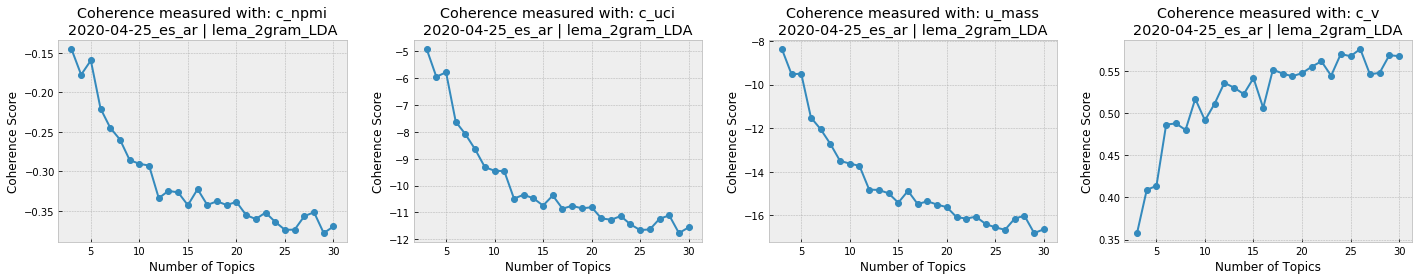

In [19]:
import matplotlib.pyplot as plt

with plt.style.context("bmh"):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 4))

    for i, score in enumerate(scores_disponibles):
        ax = axes.flat[i]
        ax.plot(scores.num_topics, scores[score], "-o")
        ax.set_title(f"Coherence measured with: {score}\n{corpus_minilabel} | {model_label}")
        ax.set_xlabel("Number of Topics")
        ax.set_ylabel("Coherence Score")
    
    plt.tight_layout()
    plt.savefig(f'modelos_gensim/{corpus_minilabel}-{model_label}-coherence.png')
    plt.show()

Now that we know which are the best models, we can visualize the topics of those models.

## Visualizing the models

On this step, we use pyLDAvis to visualize the models that obtained the best scores for topic coherence.

In [20]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

def cargar_modelo_y_graficar(ntopics, dictionary, doc_term_matrix, verbose=False):
    '''
    ntopics: numero de topics
    tweets_procesados: lista de tweets que son listas de strings
    '''
    ldamodel = cargar_modelo_LDA(ntopics)
    
    if verbose:
        print(f"** Modelo con #topics = {ntopics} **")
        for i in range(ntopics):
            topic_words_and_weights = ldamodel.show_topic(i)
            topic_words = " ".join([word for word, weight in topic_words_and_weights])
            print(f" * ", topic_words)
        print()
    
    return pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary)

In [21]:
cargar_modelo_y_graficar(3,dictionary, doc_term_matrix) 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.189925 -0.029714       1        1  37.980114
1      0.123963 -0.131096       2        1  31.016069
2      0.065963  0.160810       3        1  31.003813, topic_info=           Term        Freq       Total Category  logprob  loglift
3          caso  320.000000  320.000000  Default  30.0000  30.0000
416        hijo  129.000000  129.000000  Default  29.0000  29.0000
117      nombre  146.000000  146.000000  Default  28.0000  28.0000
64   nuevo_caso  101.000000  101.000000  Default  27.0000  27.0000
461        ciro  190.000000  190.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
241    historia   13.858104   21.500568   Topic3  -5.7865   0.7319
151  cuarentena   18.983335   76.256790   Topic3  -5.4718  -0.2195
393      crisis   15.268446   36.670372   Topic3  -5.6896   0.2949
437         san   13.617776   21.060604   Topic3  -5.8040   0.7350
17         pais   13.619982   85.205505   Topic3  -5.8038  -0.6625

[169 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
703       2  0.660958            #covid
703       3  0.330479            #covid
691       2  0.935112  #distanciamiento
1373      3  0.967817     #nolosliberen
1034      2  0.950220             adema
...     ...       ...               ...
106       2  0.796180              vida
106       3  0.212315              vida
520       1  0.980754           viernes
74        1  0.062186             virus
74        2  0.932797             virus

[179 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

In [23]:
cargar_modelo_y_graficar(5,dictionary, doc_term_matrix)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.183266  0.140421       1        1  25.733576
0      0.201948  0.142899       2        1  23.633430
4     -0.025403 -0.062491       3        1  18.724997
2     -0.051092 -0.073970       4        1  17.834982
1      0.057813 -0.146859       5        1  14.073016, topic_info=         Term        Freq       Total Category  logprob  loglift
3        caso  333.000000  333.000000  Default  30.0000  30.0000
461      ciro  183.000000  183.000000  Default  29.0000  29.0000
117    nombre  141.000000  141.000000  Default  28.0000  28.0000
416      hijo  125.000000  125.000000  Default  27.0000  27.0000
644     beber  122.000000  122.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
149  pandemia   14.120675  111.823494   Topic5  -4.9779  -0.1084
98        dia   12.623306  137.583771   Topic5  -5.0900  -0.4278
22      gente    9.197598   58.005280   Topic5  -5.4066   0.1193
422    barrio    7.873439   33.798653   Topic5  -5.5620   0.5040
177      casa    7.147989   40.525627   Topic5  -5.6587   0.2258

[298 rows x 6 columns], token_table=      Topic      Freq              Term
term                                   
1140      4  0.979584            #ahora
197       2  0.921091        #argentina
691       1  0.072864  #distanciamiento
691       2  0.728636  #distanciamiento
691       3  0.145727  #distanciamiento
...     ...       ...               ...
520       1  0.985972           viernes
74        1  0.250294             virus
74        2  0.584019             virus
74        3  0.083431             virus
74        5  0.083431             virus

[394 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 5, 3, 2])

We can save the graphics to share them in other applications, like our project website:

In [24]:
def guardar_grafico(topic_nr, model_label):
    pyLDAvis.save_html(cargar_modelo_y_graficar(topic_nr, dictionary, doc_term_matrix), f'modelos_gensim/{corpus_minilabel}-{model_label}_ntopics{topic_nr:02}.html')

In [25]:
guardar_grafico(3, model_label)

In [26]:
guardar_grafico(5, model_label)

We can try other visualizations, like a circle pack plot, that gives us a good idea of the main words of each topic at a glance:

In [28]:
import pandas as pd
def hacer_csv_para_rawgraphsio(modelo, out_fp, top_n=10):
    records = []
    
    for i in range(modelo.num_topics):
        for word, weight in modelo.show_topic(i, topn=top_n):
            records.append((i, word, weight))

    df = pd.DataFrame(records, columns=["topic_id", "word", "weight"])
    df = df.groupby("topic_id").head(top_n).reset_index(drop=True)
    print(f"Escribiendo CSV en: {out_fp}")
    df.to_csv(out_fp, index=False)
    
topic_nr=5
modelo = cargar_modelo_LDA(ntopics=topic_nr)
fp = f"modelos_gensim/{corpus_minilabel}-{model_label}_ntopics{topic_nr:02}.csv"
hacer_csv_para_rawgraphsio(modelo, fp)

Escribiendo CSV en: modelos_gensim/2020-04-25_es_ar-lema_2gram_LDA_ntopics05.csv


<img src="modelos_gensim/modelo.05.tokens.png" />